# Simple Variational Inference

http://machine-learning.hatenablog.com/entry/2016/01/23/130017  
http://machine-learning.hatenablog.com/entry/2016/01/31/172500

In [1]:
!date

2019年 8月19日 月曜日 16時00分58秒 JST


In [2]:
%matplotlib inline
%matplotlib nbagg

import warnings

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from matplotlib.animation import ArtistAnimation
from IPython.display import HTML, display

warnings.filterwarnings('ignore')
plt.style.use('seaborn-darkgrid')
plt.rcParams['image.cmap'] = 'viridis'
sns.set_context('talk')

# Gaussian distribution

In [3]:
class MultiGauss:
    def __init__(self, mean=[0., 0.], lmd=[[1., 0.5], [0.5, 1.]]):
        
        assert len(mean) == len(lmd)
        
        # Prior
        self._mean = np.array(mean)
        self._lmd = np.array(lmd)  # precision

    def pdf(self, res=None):
        if res is None:
            res = 100

        w, v = np.linalg.eig(self._lmd)
        d = np.arange(res) * (2 * np.pi / res)
        
        c = 1.0
        a = np.sqrt(c * w[0])
        b = np.sqrt(c * w[1])
        
        p1 = a * np.cos(d)
        p2 = b * np.sin(d)
        
        mat = self._mean[:, None] + np.dot(v.T, np.array([p1, p2]))
        
        # Connect first and last points
        mat = np.concatenate([mat, mat.T[0, None].T], axis=1)
        
        return mat
    
    @property
    def mean(self):
        return self._mean
    
    @property
    def lmd(self):
        return self._lmd

In [4]:
class ApproximateGauss:
    def __init__(self, gauss):

        assert isinstance(gauss, (MultiGauss))
        
        # Distribution
        self.gauss = gauss
        
        # Prior
        self.mu0 = None
        self.mu1 = None
        
        self.lmd0 = gauss.lmd[0][0]
        self.lmd1 = gauss.lmd[1][1]
        
        self._mean = None
        self._lmd = None
        
    def inference(self):
        
        if self.mu1 is None:
            self.mu1 = np.random.random()
                
        # mu posterior
        self.mu0 = (self.gauss.mean[0] - self.gauss.lmd[0][0] ** -1
                    * self.gauss.lmd[0][1] * (self.mu1 - self.gauss.mean[1]))
        
        self.mu1 = (self.gauss.mean[1] - self.gauss.lmd[1][1] ** -1
                    * self.gauss.lmd[1][0] * (self.mu0 - self.gauss.mean[0]))

    def pdf(self, res=100, c=1.0):

        if (self.mu0 is None) or (self.mu1 is None):
            raise 'Do inference'
            
        mu = np.array([self.mu0, self.mu1])
        lmd = np.array([[self.lmd0, 0], [0, self.lmd1]])
            
        w, v = np.linalg.eig(np.linalg.inv(lmd))
        d = np.arange(res) * (2 * np.pi / res)
        
        a = np.sqrt(c * w[0])
        b = np.sqrt(c * w[1])
        
        p1 = a * np.cos(d)
        p2 = b * np.sin(d)
        
        mat = mu[:, None] + np.dot(v.T, np.array([p1, p2]))
        
        # Connect first and last points
        mat = np.concatenate([mat, mat.T[0, None].T], axis=1)
        
        return mat
    
    @property
    def mean(self):
        return np.array([self.mu0, self.mu1])
    
    @property
    def lmd(self):
        return np.array([[self.lmd0, 0], [0, self.lmd1]])

# Data

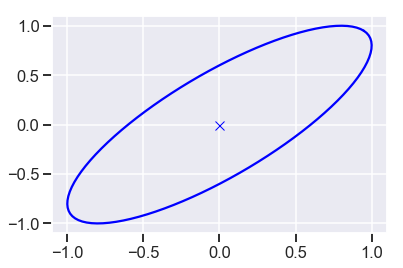

In [6]:
gauss = MultiGauss(lmd=[[1, -0.8], [-0.8, 1]])
mat = gauss.pdf()

plt.plot(mat[0], mat[1], color='b')
plt.plot(*gauss.mean, 'x', color='b')
plt.show()

# VI

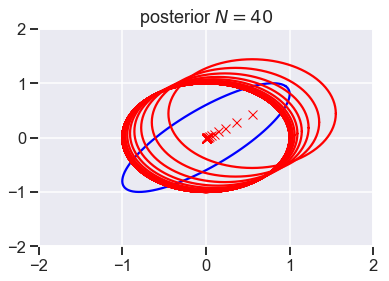

In [7]:
N = 40
gauss = MultiGauss(lmd=[[1, -0.8], [-0.8, 1]])
dist = ApproximateGauss(gauss)

frames = []
fig, ax = plt.subplots()
ax.set_title(r'posterior $N = {}$'.format(N))
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.plot(*gauss.pdf(), color='b')
ax.plot(*gauss.mean, 'x', color='b')

for i in range(N):
    dist.inference()
    im1 = ax.plot(*dist.pdf(), c='r')
    im2 = ax.plot(*dist.mean, 'x', c='r')
    frames.append(im1 + im2)

In [8]:
ani = ArtistAnimation(fig, frames)
HTML(ani.to_jshtml())